In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import time
import random


/home/cesar/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from keras.models import Model
from keras.layers import Input, concatenate
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.utils.io_utils import HDF5Matrix
import h5py

%matplotlib inline

Using TensorFlow backend.


In [3]:
if tf.test.gpu_device_name():
    print('Default GPU {}'.format(tf.test.gpu_device_name()))
else:
    print('****NO GPU DETECTED****')

Default GPU /device:GPU:0


In [4]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.model_selection import train_test_split
import shapely.wkt
import shapely.affinity
from shapely.geometry import MultiPolygon, Polygon
from keras.optimizers import Adam,Nadam, Adadelta, Adamax, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from collections import defaultdict
from shapely.wkt import loads as wkt_loads
import tifffile as tiff

In [5]:
train_path = 'train_wkt_v4.csv'
grid_path = 'grid_sizes.csv'
train = pd.read_csv(train_path)
grid = pd.read_csv(grid_path)

In [6]:
train.head()

,ImageId,ClassType,MultipolygonWKT
0,6040_2_2,1,MULTIPOLYGON EMPTY
1,6040_2_2,2,MULTIPOLYGON EMPTY
2,6040_2_2,3,MULTIPOLYGON EMPTY
3,6040_2_2,4,MULTIPOLYGON (((0.003025 -0.007879000000000001...
4,6040_2_2,5,MULTIPOLYGON (((0.005311 -0.009044999999999999...


In [7]:
train.tail()

,ImageId,ClassType,MultipolygonWKT
245,6100_2_2,6,"MULTIPOLYGON (((0.006102 -0.009042, 0.00642 -0..."
246,6100_2_2,7,MULTIPOLYGON (((0.007887999999999999 -0.009042...
247,6100_2_2,8,"MULTIPOLYGON (((0.002119 -0.001417, 0.002132 -..."
248,6100_2_2,9,"MULTIPOLYGON (((0.008021 -0.003252, 0.00803399..."
249,6100_2_2,10,"MULTIPOLYGON (((0.003194 -0.0089, 0.003201 -0...."


In [8]:
grid.head()

,Unnamed: 0,Xmax,Ymin
0,6120_2_4,0.009180,-0.00904
1,6120_2_3,0.009169,-0.00904
2,6120_2_2,0.009188,-0.00904
3,6120_2_1,0.009188,-0.00904
4,6120_2_0,0.009188,-0.00904


In [9]:
grid.tail()

,Unnamed: 0,Xmax,Ymin
445,6130_1_4,0.009169,-0.009040
446,6130_1_3,0.009188,-0.009040
447,6130_1_2,0.009150,-0.009042
448,6130_1_1,0.009004,-0.009045
449,6130_1_0,0.009188,-0.009040


In [10]:
subs_path = 'sample_submission.csv'
submission = pd.read_csv(subs_path)

In [11]:
submission.head()

,ImageId,ClassType,MultipolygonWKT
0,6120_2_4,1,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
1,6120_2_4,2,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
2,6120_2_4,3,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
3,6120_2_4,4,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
4,6120_2_4,5,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."


In [12]:
submission.tail()

,ImageId,ClassType,MultipolygonWKT
4285,6130_1_0,6,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
4286,6130_1_0,7,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
4287,6130_1_0,8,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
4288,6130_1_0,9,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
4289,6130_1_0,10,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."


In [13]:
grid.head()

,Unnamed: 0,Xmax,Ymin
0,6120_2_4,0.009180,-0.00904
1,6120_2_3,0.009169,-0.00904
2,6120_2_2,0.009188,-0.00904
3,6120_2_1,0.009188,-0.00904
4,6120_2_0,0.009188,-0.00904


In [14]:
new_grid = grid.rename(index=str, columns={"Unnamed: 0": "ImageId"})


In [15]:
new_grid.tail()

,ImageId,Xmax,Ymin
445,6130_1_4,0.009169,-0.009040
446,6130_1_3,0.009188,-0.009040
447,6130_1_2,0.009150,-0.009042
448,6130_1_1,0.009004,-0.009045
449,6130_1_0,0.009188,-0.009040


In [16]:
classes = ['Building','Misc', 'Road', 'Track', 'Trees', 'Crops', 'Waterway'
          , 'Standing_water', 'Vehicle_Large', 'Vehicle_small']


In [17]:
img_id = sorted(train.ImageId.unique())

In [18]:
img_id

['6010_1_2',
 '6010_4_2',
 '6010_4_4',
 '6040_1_0',
 '6040_1_3',
 '6040_2_2',
 '6040_4_4',
 '6060_2_3',
 '6070_2_3',
 '6090_2_0',
 '6100_1_3',
 '6100_2_2',
 '6100_2_3',
 '6110_1_2',
 '6110_3_1',
 '6110_4_0',
 '6120_2_0',
 '6120_2_2',
 '6140_1_2',
 '6140_3_1',
 '6150_2_3',
 '6160_2_1',
 '6170_0_4',
 '6170_2_4',
 '6170_4_1']

In [19]:
# Global Var
n_split = 15
patch_size = 224
class_type = 1



In [20]:
def getImageBand(img_id, img_band):
    if img_band == 'RGB':
        filename = os.path.join( 'three_band', '{}.tif'.format(img_id))
    else:
        filename = os.path.join('sixteen_band', '{}_{}.tif'.format(img_id, img_band))
    
    img = tiff.imread(filename)
    if img_band == 'P':
        img = img[:, :, None] 
    else:
        img = np.rollaxis(img, 0, 3)
        
    if img_band == 'A':
        img = img.astype(np.float32)/16384
    else:
        img = img.astype(np.float32)/2048

    return img

In [21]:
#Resize Images and Join of all bands
def getImageAllBand(img_id, scale_size = patch_size*n_split):
    img_RGB = cv2.resize(getImageBand(img_id, 'RGB'), (scale_size, scale_size))
    img_M = cv2.resize(getImageBand(img_id, 'M'), (scale_size, scale_size))
    img_A = cv2.resize(getImageBand(img_id, 'A'), (scale_size, scale_size))
    img_P = cv2.resize(getImageBand(img_id, 'P'), (scale_size, scale_size))
    img = np.concatenate((img_RGB, img_M, img_A, img_P[:, :, None]), axis=2)
    return img

In [22]:
# Plot Images's bands
def plotImageAllBand(img_id):
    img = getImageAllBand(img_id)
    plt.figure(figsize=[15, 12])
    names = ['R', 'G', 'B']
    for i in range(1, 9):
        names.append('M_{}'.format(i))
    for i in range(1, 9):
        names.append('A_{}'.format(i))
    names.append('P')
    for i in range(1, 21):
        plt.subplot(4, 5, i)
        plt.imshow(img[:, :, i-1], cmap=plt.get_cmap('gist_ncar'))
        plt.title(names[i-1])
    plt.show()

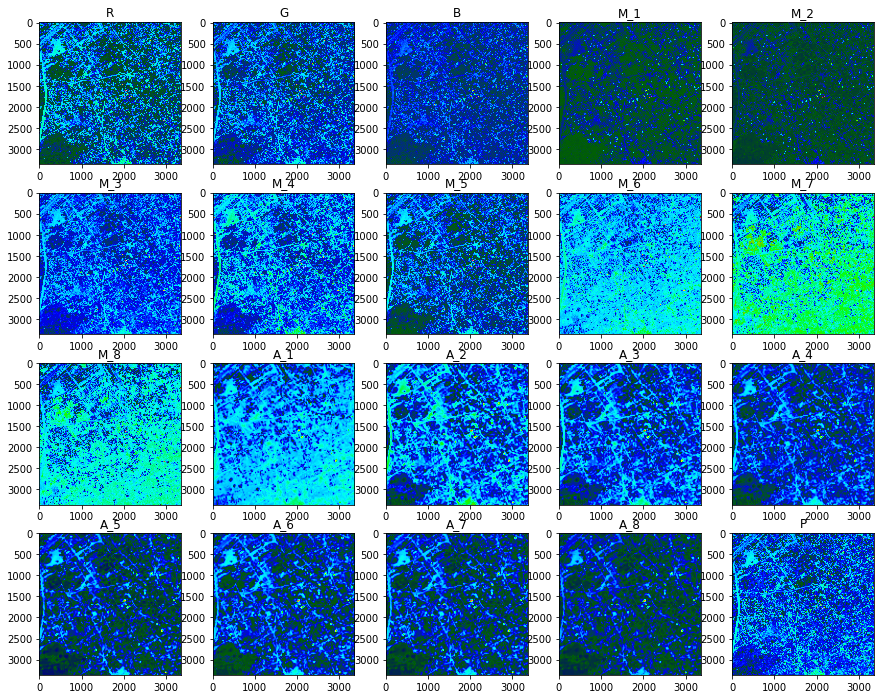

In [23]:
plotImageAllBand(img_id[12])

In [24]:
def convertCoordinatesToRaster(coords, img_size, xymax):
    Xmax, Ymax = xymax
    H, W = img_size
    w1 = 1.0 * W * W /(W+1)
    h1 = 1.0 * H * H /(H+1)
    xf = w1/Xmax
    yf = h1/Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coord = np.round(coords).astype(np.int32)
    return coord

def getXmaxYmin(grid_size_, img_id_):
    xmax, ymin = grid_size_[grid_size_.ImageId == img_id_].iloc[0, 1:].astype(float)
    return (xmax, ymin)

def getPolygonList(list_pd, img_id_, cType):
    df_img = list_pd[list_pd.ImageId == img_id_]
    multipoly = df_img[df_img.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly) > 0:
        assert len(multipoly) == 1
        polygonList = wkt_loads(multipoly.values[0])
    return polygonList

def getAndConvertContours(polygonList, raster_img_size, xymax):
    per_list = []
    interior_list = []
    if polygonList is None:
        return None
    for i in range(len(polygonList)):
        poly = polygonList[i]
        per = np.array(list(poly.exterior.coords))
        per_ = convertCoordinatesToRaster(per, raster_img_size, xymax)
        per_list.append(per_)
        for j in poly.interiors:
            interior = np.array(list(j.coords))
            interior_ = convertCoordinatesToRaster(interior, raster_img_size, xymax)
            interior_list.append(interior_)
    return per_list, interior_list

def plotMaskFromContours(raster_img_size, contours, class_value=1):
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    per_list, interior_list = contours
    cv2.fillPoly(img_mask, per_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask

def generateMaskForImageAndClass(raster_size, Img_Id, class_type, grid_sizes_pd=new_grid
                                ,wkt_list_pd=train ):
    xymax = getXmaxYmin(grid_sizes_pd, Img_Id)
    polygon_list = getPolygonList(wkt_list_pd, Img_Id, class_type)
    contours = getAndConvertContours(polygon_list, raster_size, xymax)
    mask = plotMaskFromContours(raster_size, contours, 1)
    return mask

def plotMaskAllBand(image_id_):
    img = getImageAllBand(image_id_)
    plt.figure(figsize=[15, 6])
    for i in range(1, 11):
        plt.subplot(2, 5, i)
        mask = generateMaskForImageAndClass((img.shape[0], img.shape[1]), image_id_, i)
        plt.imshow(mask[:, :], cmap=plt.get_cmap('gist_ncar'))
        plt.title(classes[i-1])
    plt.show()
            
            
            

In [25]:
new_grid.head()

,ImageId,Xmax,Ymin
0,6120_2_4,0.009180,-0.00904
1,6120_2_3,0.009169,-0.00904
2,6120_2_2,0.009188,-0.00904
3,6120_2_1,0.009188,-0.00904
4,6120_2_0,0.009188,-0.00904


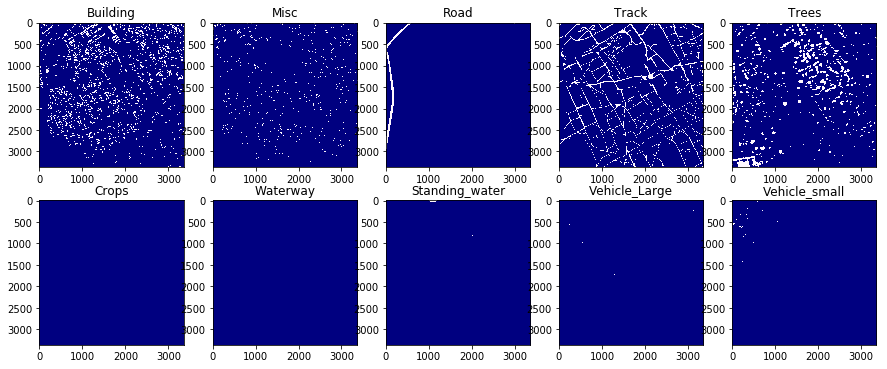

In [27]:
plotMaskAllBand(img_id[12])

# Get Random Patches

In [28]:
def getPatch(img_id_, pos = 1):
    N_patch = np.power(n_split, 2)
    all_ = []
    img = getImageAllBand(img_id_)
    mask = generateMaskForImageAndClass((img.shape[0], img.shape[1]), img_id_, 1)
    for i in range(n_split):
        for j in range(n_split):
            y = mask[patch_size * i:patch_size*(i+1), patch_size*j:patch_size*(j+1)]
            if ((pos==1) and (np.sum(y) > 0)) or (pos == 0):
                x = img[patch_size*i:patch_size*(i+1), patch_size*j:patch_size*(j+1), :]
                all_.append(np.concatenate((x, y[:, :, None]), axis=2))
    all_ = np.asarray(all_)
    return all_

def getAllPatches(pos = 1):
    x = []
    count = 0
    for image in img_id:
        all_ = getPatch(image, pos = pos)
        if len(all_) > 0:
            count += 1
            if count == 1:
                x = all_
            else:
                x = np.concatenate((x, all_), axis=0)
    if pos ==1:
        np.save('output/data_pos_%d_%d_class%d'%(patch_size, n_split, 1), x)
    else:
        np.save('output/data_%d_%d_class%d'% (patch_size, n_split, 1), x)

    print (x.shape)
    return x

In [29]:
def normalizePatches():
    data = getAllPatches()
    img = data[:, :, :, :20]
    msk = data[:, :, :, 20]
    mean = np.mean(img)
    std = np.std(img)
    img = (img - mean)/std
    print (mean, std)
    print (np.mean(img), np.std(img))
    return img, msk

In [30]:
img, msk = normalizePatches()

(1194, 224, 224, 21)
0.2297978 0.09701497
6.151487e-06 1.0000004


In [31]:
def postNormalize(img, mean=0.229798, std=0.097015):
    img = (img - mean)/std
    return img

In [32]:
def get_unet_5():
#     Patch_size = 224
    inputs = Input((patch_size, patch_size, 20))

    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    #conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    #conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
   
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    #conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    #conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    #conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4, up6], axis = 3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    #conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    #conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    #conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    
    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    #conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    #model.add(activation='softmax')
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [48]:
x_trn, x_val, y_trn, y_val = train_test_split(img, msk,test_size=0.2, random_state=0)
y_trn = y_trn[:,:,:,None]
y_val = y_val[:,:,:,None]
model = get_unet_5()
#x_trn.shape

In [49]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 20) 0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 224, 224, 32) 5792        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 112, 112, 32) 0           conv2d_29[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 112, 112, 64) 18496       max_pooling2d_9[0][0]            
__________________________________________________________________________________________________
max_poolin

In [50]:
model_checkpoint = ModelCheckpoint('unet_{epoch:02d}', monitor='val_acc', verbose=1)
history = model.fit(x_trn, y_trn, batch_size=32, epochs=40, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint], validation_data=(x_val, y_val))

Train on 955 samples, validate on 239 samples
Epoch 1/40
955/955 [==============================] - 11s 12ms/step - loss: 0.3550 - acc: 0.8433 - val_loss: 0.3303 - val_acc: 0.8685

Epoch 00001: saving model to unet_01
Epoch 2/40
955/955 [==============================] - 11s 12ms/step - loss: 0.2705 - acc: 0.8977 - val_loss: 0.2546 - val_acc: 0.9062

Epoch 00002: saving model to unet_02
Epoch 3/40
955/955 [==============================] - 11s 12ms/step - loss: 0.2404 - acc: 0.9102 - val_loss: 0.2373 - val_acc: 0.9096

Epoch 00003: saving model to unet_03
Epoch 4/40
955/955 [==============================] - 11s 12ms/step - loss: 0.2326 - acc: 0.9117 - val_loss: 0.2383 - val_acc: 0.9101

Epoch 00004: saving model to unet_04
Epoch 5/40
955/955 [==============================] - 11s 12ms/step - loss: 0.2213 - acc: 0.9165 - val_loss: 0.2157 - val_acc: 0.9178

Epoch 00005: saving model to unet_05
Epoch 6/40
955/955 [==============================] - 11s 12ms/step - loss: 0.2105 - acc: 0.91

In [40]:
f = h5py.File('unet_01', 'r')
datasets = [n for n in f.keys()]
data = f[datasets[1]]

In [43]:
name = list(f.keys())[1]
#name2 = list(name)[1]
data = list(f[name])
data
#t = list(f.keys())

['Adam_1', 'training']

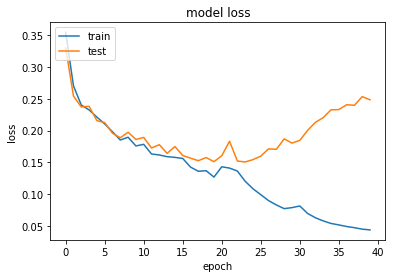

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


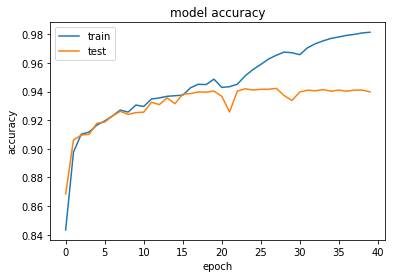

In [52]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [138]:
data1 = data[group[1]]
group_n = [n for n in data1]
data2 = data[group[0]]

In [39]:
test = model.evaluate(x_val, y_val)
print('Testing results:{}'.format(test[1]))

239/239 [==============================] - 1s 4ms/step
Testing results:0.9409983115714963


# Adding Dropout 

In [53]:
def get_unet_dropout():
#     Patch_size = 224
    inputs = Input((patch_size, patch_size, 20))

    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    #conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    #conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
   
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    #conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    #conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Dropout(keep_prob)(conv5)
    #conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4, up6], axis = 3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Dropout(keep_prob)(conv6)
    #conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Dropout(keep_prob)(conv7)
    #conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    #conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    
    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    #conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    #model.add(activation='softmax')
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [57]:
keep_prob = 0.5
model2 = get_unet_dropout()

In [58]:
model_checkpoint = ModelCheckpoint('unet_{epoch:02d}_drop', monitor='val_acc', verbose=1)
history2 = model2.fit(x_trn, y_trn, batch_size=32, epochs=40, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint], validation_data=(x_val, y_val))

Train on 955 samples, validate on 239 samples
Epoch 1/40
955/955 [==============================] - 12s 13ms/step - loss: 0.3480 - acc: 0.8521 - val_loss: 0.2754 - val_acc: 0.8966

Epoch 00001: saving model to unet_01_drop
Epoch 2/40
955/955 [==============================] - 12s 12ms/step - loss: 0.2686 - acc: 0.8985 - val_loss: 0.2687 - val_acc: 0.8993

Epoch 00002: saving model to unet_02_drop
Epoch 3/40
955/955 [==============================] - 12s 12ms/step - loss: 0.2538 - acc: 0.9065 - val_loss: 0.2421 - val_acc: 0.9115

Epoch 00003: saving model to unet_03_drop
Epoch 4/40
955/955 [==============================] - 11s 12ms/step - loss: 0.2375 - acc: 0.9119 - val_loss: 0.2330 - val_acc: 0.9148

Epoch 00004: saving model to unet_04_drop
Epoch 5/40
955/955 [==============================] - 11s 12ms/step - loss: 0.2269 - acc: 0.9155 - val_loss: 0.2196 - val_acc: 0.9179

Epoch 00005: saving model to unet_05_drop
Epoch 6/40
955/955 [==============================] - 12s 12ms/step -

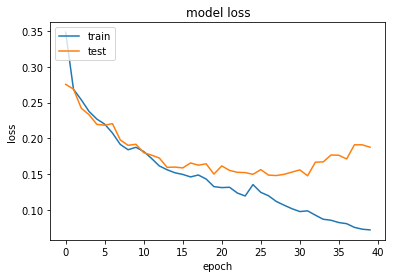

In [62]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


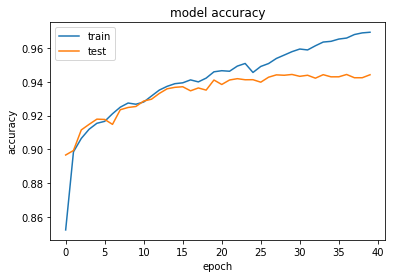

In [63]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [61]:
test2 = model2.evaluate(x_val, y_val)
print('Testing results:{}'.format(test[1]))

239/239 [==============================] - 1s 4ms/step
Testing results:0.9409983115714963
